In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import scipy.optimize as opt
from sklearn.preprocessing import OneHotEncoder

# Neural Networks

In [11]:
data = io.loadmat('../MachineLearning/data/ex4data1.mat')

In [12]:
def displayData(row):
    return row.reshape((20, 20), order='F')

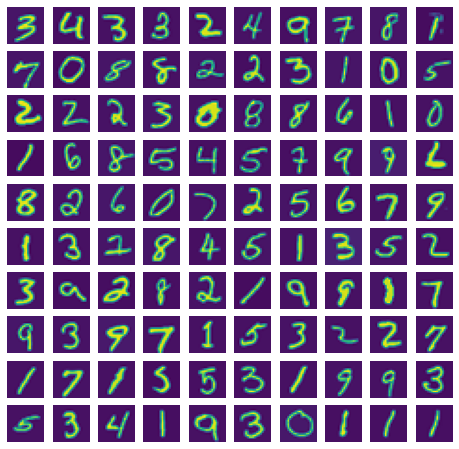

In [13]:
import random

plt.figure(figsize=(8, 8))
for i in range(100):
    plt.subplot(10, 10, i+1)
    r = random.randint(0, 4999)
    plt.imshow(displayData(data['X'][r]))
    # plt.title(data['y'][r])
    plt.axis('off')

In [14]:
weight = io.loadmat('../MachineLearning/data/ex4weights.mat')
Theta1, Theta2 = weight['Theta1'], weight['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

In [15]:
X = data['X']
y = data['y']
encoder = OneHotEncoder(sparse=False)
yOneHot = encoder.fit_transform(y)
yOneHot.shape, yOneHot[0]

((5000, 10), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [16]:
def sigmoid(z):
    return np.exp(z) / (1 + np.exp(z))

Note that you should not be regularizing the terms that correspond to the bias. For the matrices Theta1 and Theta2, this corresponds to the first column of each matrix.

In [17]:
# Feedforward and cost function
def feedForward(Theta1, Theta2, X):
    m = X.shape[0]
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values=np.ones(m), axis=1)
    z3 = a2 @ Theta2.T
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

def nnCostFunction(params, X, y, lamd):
    m = X.shape[0]
    Theta1 = params[:25 * 401].reshape((25, 401))
    Theta2 = params[25 * 401:].reshape((10, 26))
    _, _, _, _, h = feedForward(Theta1, Theta2, X)
    
    J = 0
    for i in range(m):
        inner = -y[i] @ np.log(h[i]).T - (1 - y[i]) @ np.log(1 - h[i]).T
        J += inner
    J += lamd / 2 * (np.sum(np.power(Theta1[:, 1:], 2)) + np.sum(np.power(Theta2[:, 1:], 2)))

    return J / m

In [18]:
# nnCostFunction(Theta1, Theta2, X, yOneHot, 1)

# 2-Backpropagation

In [19]:
# 2.1-Sigmoid gradient
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [20]:
# 2.2-Random initialization
# np.random.random(size) 返回一个size大小的0-1随机浮点数数组 
epsilon_init = 0.12
params = np.random.random(25 * 401 + 10 * 26) * 2 * epsilon_init - epsilon_init

In [21]:
# 2.3-Backpropagation
def backpropagation(params, X, y, lamd):
    m = X.shape[0]
    Theta1 = params[:25 * 401].reshape((25, 401))
    Theta2 = params[25 * 401:].reshape((10, 26))

    # 1-run the feed-forward pass
    a1, z2, a2, _, h = feedForward(Theta1, Theta2, X)
    
    # 2-compute the delta of output layer
    delta3 = h - y

    # 3-compute the delta of hiddent layer
    z2 = np.insert(z2, 0, values=np.ones(z2.shape[0]), axis=1)
    delta2 = delta3 @ Theta2 * sigmoidGradient(z2)

    # 4-accumulate the gradient
    Delta2 = delta3.T @ a2
    Delta1 = delta2[:, 1:].T @ a1

    # 5-obtain the (unregularized)gradient
    Delta2 /= m
    Delta1 /= m

    # add the gradient regularization term
    Delta1[:, 1:] = Delta1[:, 1:] + Theta1[:, 1:] * lamd / m
    Delta2[:, 1:] = Delta2[:, 1:] + Theta2[:, 1:] * lamd / m

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(Delta1), np.ravel(Delta2)))
    return grad

In [22]:
res = opt.fmin_tnc(func=nnCostFunction, x0=params, fprime=backpropagation, args=(X, yOneHot, 1))

  NIT   NF   F                       GTG
    0    1  6.478901895771696E+00   1.10928880E+01
    1    4  3.352977349504832E+00   2.75589494E-01
    2    8  3.205418813567681E+00   7.99047387E-02
    3   11  3.142785855186230E+00   7.40111697E-02
    4   15  2.980374901479327E+00   3.59026799E-01
    5   19  2.569650112820951E+00   7.15605460E-01
    6   26  2.195156944308097E+00   5.83106908E-01
tnc: stepmx = 1000
    7   31  1.443735726179251E+00   8.90038974E-02
    8   42  1.188241625710991E+00   8.59288128E-02
    9   55  9.225590952573038E-01   4.48456248E-02
   10   59  7.503459105332739E-01   8.98758446E-03
   11   76  6.415412809852477E-01   1.11063427E-02
   12   80  5.803804890433220E-01   3.64980440E-03
   13   98  5.475147551520331E-01   6.33309571E-03
   14  109  5.338283973226930E-01   8.59453631E-03
   15  113  4.965323122402449E-01   6.86671065E-04
tnc: fscale = 35.9769
   16  139  4.400101845690072E-01   3.07175335E-03
   17  167  4.075827382733326E-01   1.94789399E-03


In [23]:
Theta1Final = res[0][:25 * 401].reshape((25, 401))
Theta2Final = res[0][25 * 401:].reshape((10, 26))
_, _, _, _, h = feedForward(Theta1Final, Theta2Final, X)
yPred = np.array(np.argmax(h, axis=1) + 1)

In [24]:
counter = 0
for i in range(y.shape[0]):
    if y[i] == yPred[i]:
        counter += 1

print(f"Accuracy: {counter / y.shape[0]}")

Accuracy: 0.9964


In [26]:
# 3-Visualizing the hidden layer
hiddenLayer = Theta1Final[:, 1:]
hiddenLayer.shape

(25, 400)

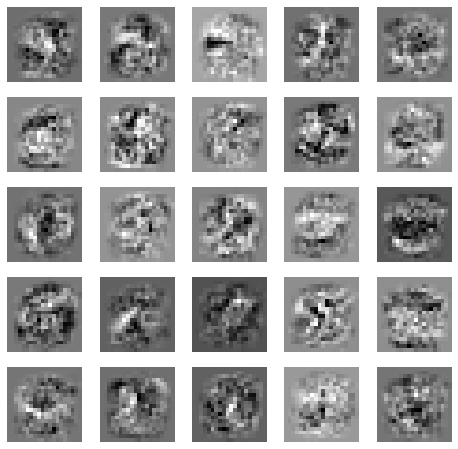

In [30]:
plt.figure(figsize=(8, 8))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(displayData(hiddenLayer[i]), cmap='binary')
    plt.axis('off')